In [1]:
import datasets

ds = datasets.load_dataset('VectorGraphics/svg_corpus', data_files=["00.*", "01.*", "02.*", "04.*"])

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ds['train'][0]

{'filename': '00c6f52e4f226dc3d68c25e76387745f.svg',
 'content': '<svg xmlns:ns0="http://www.w3.org/xml/1998/namespace" ns0:space="preserve" viewBox="0 0 256 256"><path fill="#ABBF7B" d="M94 7 249 162 251 153 103 5zM4 105 151 252 161 250 6 95zM239 71 185 17 165 9 247 91zM25 56 200 231 207 226 30 49zM9 86 170 247 178 244 12 78zM150 5 136 3 253 120 251 106zM16 70 186 240 194 236 20 63zM36 43 213 220 219 215 41 37zM77 14 242 179 246 171 85 10zM61 22 234 195 239 187 69 17zM113 4 252 143 253 132 124 3zM48 31 225 208 230 202 54 26zM4 151 105 252 118 254 2 138zM2 126 130 254H141L2 115zM16 186 70 240 89 249 7 167z"/><path fill="#C9E091" d="M185 17 239 71Q220 36 185 17M247 91 165 9 150 5 251 106zM127 3H124L253 132V120L136 3zM103 5 251 153 252 143 113 4zM85 10 246 171 249 162 94 7zM69 17 239 187 242 179 77 14zM54 26 230 202 234 195 61 22zM41 37 219 215 225 208 48 31zM30 49 207 226 213 220 36 43zM20 63 193 236 200 231 25 56zM12 78 178 244 186 240 16 70zM6 95 161 250 170 247 9 86zM2 115 141 253 15

In [24]:
# SVG-теги: полные открывающие, закрывающие и только префиксы открывающих
SVG_TAGS = [
    "<svg>", "</svg>", "<svg",
    "<path>", "</path>", "<path",
    "<rect>", "</rect>", "<rect",
    "<circle>", "</circle>", "<circle",
    "<ellipse>", "</ellipse>", "<ellipse",
    "<line>", "</line>", "<line",
    "<polyline>", "</polyline>", "<polyline",
    "<polygon>", "</polygon>", "<polygon",
    "<g>", "</g>", "<g",
    "<defs>", "</defs>", "<defs",
    "<linearGradient>", "</linearGradient>", "<linearGradient",
    "<radialGradient>", "</radialGradient>", "<radialGradient",
    "<stop>", "</stop>", "<stop",
    "<text>", "</text>", "<text",
    "<tspan>", "</tspan>", "<tspan",
]

# SVG-атрибуты как отдельные токены
SVG_ATTRIBUTES = [
    "width", "height",
    "viewBox", "preserveAspectRatio",
    "x", "y", "dx", "dy",
    "cx", "cy", "r", "rx", "ry",
    "fill", "fill-rule", "fill-opacity",
    "stroke", "stroke-width", "stroke-linecap",
    "stroke-linejoin", "stroke-miterlimit",
    "stroke-dasharray", "stroke-dashoffset",
    "opacity",
    "d",        # path data
    "points",   # polyline/polygon
    "transform", "translate", "rotate", "scale",
    "skewX", "skewY", "matrix",
    "clip-path", "mask", "filter",
    "gradientUnits", "gradientTransform", "spreadMethod",
    "stop-color", "stop-opacity", "offset",
    "id", "class", "style",
    "role", "aria-label", "xmlns",
]

XMLNS_URLS = [
    'http://www.w3.org/2000/svg',
    'http://www.w3.org/1999/xlink',
]

# Объединяем все специальные токены
SPECIAL_TOKENS = SVG_TAGS + SVG_ATTRIBUTES + XMLNS_URLS

In [ ]:
from datasets import load_dataset
from datasets import interleave_datasets
from transformers import AutoTokenizer
from transformers import BertConfig, BertTokenizerFast, BertModel
from tqdm import tqdm
import os


def get_training_corpus(training_corpus):
    for item in tqdm(training_corpus):
        yield item['content']

def get_basic_tokenizer():
    old_tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
    return old_tokenizer

def train_new_tokenizer(old_tokenizer, training_corpus, vocab_size):
    old_special_tokens = [x for x in list(old_tokenizer.added_tokens_decoder.values()) if x.special]
    special = old_special_tokens + SPECIAL_TOKENS
    
    tokenizer = old_tokenizer.train_new_from_iterator(
        training_corpus,
        vocab_size=vocab_size,
        min_frequency=3, 
        new_special_tokens=special,
    )
    return tokenizer

vocab_size = 50280 * 4 - 21 # for extra tokens as in ModerBert

# training_corpus = get_training_corpus()
old_tokenizer = get_basic_tokenizer()

new_tokenizer = train_new_tokenizer(old_tokenizer, get_training_corpus(ds['train']), vocab_size)

for i in old_tokenizer.added_tokens_decoder:
    a = old_tokenizer.added_tokens_decoder[i]
    if a.special == False:
        new_tokenizer.add_tokens(a)

100%|██████████| 253584/253584 [00:38<00:00, 6603.24it/s]


In [28]:
new_tokenizer.save_pretrained('svg_tokenizer')

('svg_tokenizer5/tokenizer_config.json',
 'svg_tokenizer5/special_tokens_map.json',
 'svg_tokenizer5/tokenizer.json')

In [29]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('svg_tokenizer')

/tmp/ipykernel_777869/2592497358.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


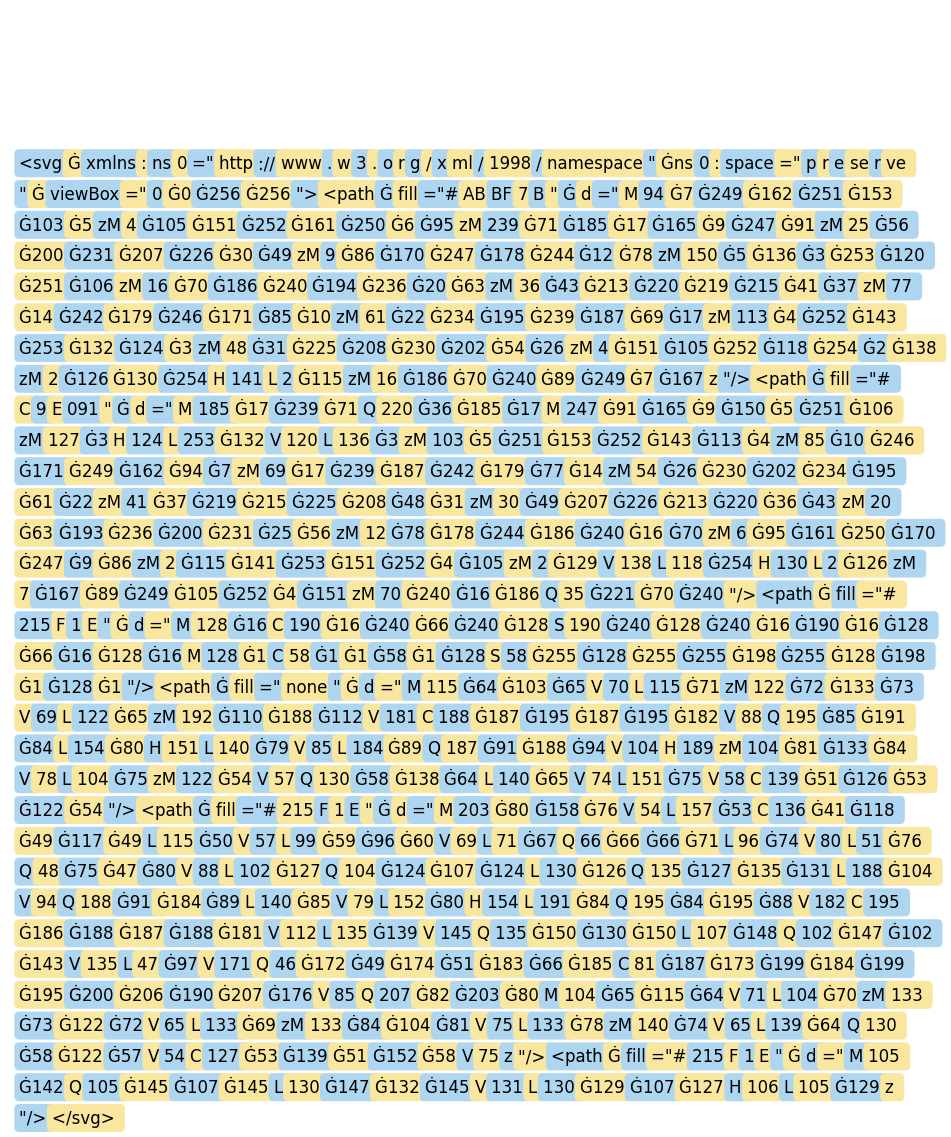

2164 800


In [32]:
import matplotlib.pyplot as plt

svg = ds['train']['content'][0]

tokens = tokenizer.tokenize(svg)

colors = ["#AED6F1", "#F9E79F"]  # light blue & light yellow

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis("off")

x, y = 0.01, 0.5
for i, tok in enumerate(tokens):
    disp = tok + " "
    c = colors[i % 2]
    tb = ax.text(
        x, y, disp,
        fontsize=12, va="center", ha="left",
        bbox=dict(boxstyle="round,pad=0.3", facecolor=c, edgecolor="none")
    )
    renderer = fig.canvas.get_renderer()
    bb = tb.get_window_extent(renderer=renderer)
    bb_data = bb.transformed(ax.transData.inverted())
    x += bb_data.width
    if x > 0.95:
        x = 0.01
        y -= 0.1

plt.tight_layout()
plt.savefig("tokenization_visual.png", dpi=150)
plt.show()

print(len(svg), len(tokens))